In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_4796/2008134232.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [3]:
def create_some_data(n_per_clust):
    """
    qwerty 2
    """
    
    A = [1, 1]
    B = [5, 1]
    C = [4, 4]

    # Generate data
    a = [A[0] + np.random.randn(n_per_clust), A[1] + np.random.randn(n_per_clust)]
    b = [B[0] + np.random.randn(n_per_clust), B[1] + np.random.randn(n_per_clust)]
    c = [C[0] + np.random.randn(n_per_clust), C[1] + np.random.randn(n_per_clust)]

    # Concatanate into a matrix
    data_np   = np.hstack(tup=(a, b, c)).T

    # True labels
    labels_np = np.hstack(tup=(np.zeros(shape=(n_per_clust)), 
                            np.ones(shape=(n_per_clust)),
                            1 + np.ones(shape=(n_per_clust))))
    
    # Pul all outputs into a Dict
    output = {}
    output['data']   = torch.tensor(data_np).float()
    output['labels'] = torch.tensor(labels_np).long()

    # Use scikitlearn to split the data
    train_data, test_data, train_labels, test_labels = train_test_split(output['data'], output['labels'],
                                                       train_size=0.9)
    
    ## Step 3: Convert into PyTorch Datasets
    train_data_set = TensorDataset(train_data, train_labels)
    test_data_set  = TensorDataset(test_data, test_labels)

    # Step 4: Translate into Dataloader objects
    batch_size   = 8
    output['train_data'] = DataLoader(dataset=train_data_set, batch_size=batch_size,
                            shuffle=True, drop_last=True)
    output['test_data']  = DataLoader(dataset=test_data_set, 
                            batch_size=test_data_set.tensors[0].shape[0])
    
    return output

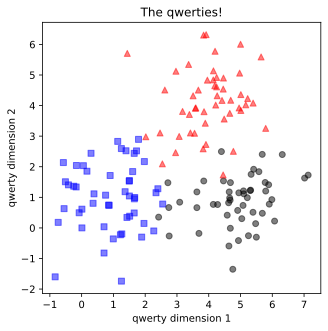

In [4]:
# Check that the function works

theData = create_some_data(50)

data = theData['data']
labels = theData['labels']

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

# Create the model

In [11]:
def create_the_qwerty_net(n_units, n_layers):

  class qwerty_net(nn.Module):
    def __init__(self, n_units, n_layers):
      super().__init__()

      # Create dictionary to store the layers
      self.layers = nn.ModuleDict()
      self.n_layers = n_layers

      # Input layer
      self.layers['input'] = nn.Linear(2, n_units) 
      
      # Didden layers
      for i in range(n_layers):
        self.layers[f'hidden{i}'] = nn.Linear(n_units, n_units) 

      # Output layer
      self.layers['output'] = nn.Linear(n_units, 3)
    

    # Forward pass
    def forward(self, x):
      # Input layer
      x = self.layers['input'](x)

      # Hidden layers
      for i in range(self.n_layers):
        x = F.relu(self.layers[f'hidden{i}'](x))
      
      # Return output layer
      x = self.layers['output'](x)
      return x
  
  # Create the model instance
  net = qwerty_net(n_units, n_layers)
  
  # Loss function
  loss_func = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net, loss_func, optimizer

In [12]:
# Test the model with fake input
n_units_per_layer = 12
n_layers = 4

net, loss_func, optimizer = create_the_qwerty_net(n_units_per_layer, n_layers)
print(net)

# Input is 10 samples
input = torch.rand(10, 2)
net(input)

qwerty_net(
  (layers): ModuleDict(
    (input): Linear(in_features=2, out_features=12, bias=True)
    (hidden0): Linear(in_features=12, out_features=12, bias=True)
    (hidden1): Linear(in_features=12, out_features=12, bias=True)
    (hidden2): Linear(in_features=12, out_features=12, bias=True)
    (hidden3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)


tensor([[0.2488, 0.0995, 0.1211],
        [0.2504, 0.0978, 0.1208],
        [0.2512, 0.0979, 0.1212],
        [0.2567, 0.0949, 0.1210],
        [0.2549, 0.0957, 0.1211],
        [0.2495, 0.0983, 0.1199],
        [0.2528, 0.0978, 0.1218],
        [0.2519, 0.0981, 0.1216],
        [0.2575, 0.0942, 0.1206],
        [0.2517, 0.0964, 0.1205]], grad_fn=<AddmmBackward0>)

# A function that trains the model

In [17]:
def train_the_model(n_units, n_layers):
    """
    DATA_DATA_VS_DEPTH_QWERTY2
    """
    
    num_epochs = 50

    # Create a new model
    net, loss_func, optimizer = create_the_qwerty_net(n_units, n_layers)

    # Initialize
    losses    = torch.zeros(num_epochs)
    train_acc = []
    test_acc  = []

    # Loop over epochs
    for epoch_i in range(num_epochs):

        # Loop over training data batches
        batch_acc  = []
        batch_loss = [] 

        for X, y in train_data:
            # Forward pass and loss
            y_hat = net(X)
            loss  = loss_func(y_hat,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batch_loss.append(loss.item())

            # Compute accuracy
            matches = torch.argmax(y_hat, axis=1) == y       # Booleans (True/False)
            matches_numeric = matches.float()                # Convert to numbers (1/0)
            accuracy_pct = 100 * torch.mean(matches_numeric) # Average and *100
            batch_acc.append(accuracy_pct)                   # Add to list of accuracies
        # End of batch loop.

        # Get the average training accuracy of the batches
        train_acc.append(np.mean(batch_acc))

        # The average losses accross the batches
        losses[epoch_i] = np.mean(batch_loss)

        # Test accuracy
        X, y = next(iter(test_data)) # Extract X, y from dataloader
        with torch.no_grad():
          y_hat = net(X)
        test_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()))

    # End epochs

    return train_acc, test_acc, losses, net

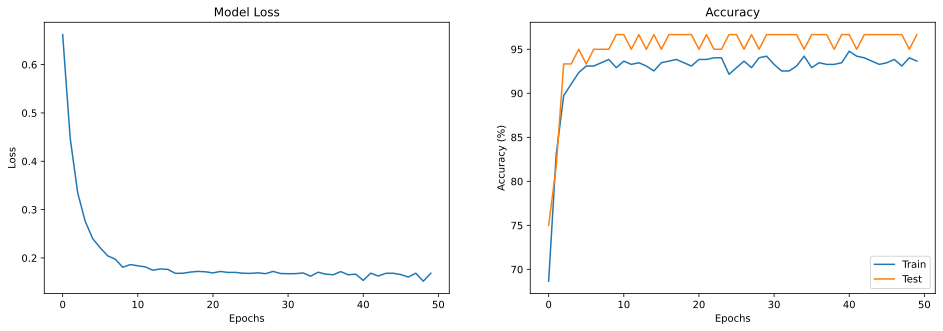

In [18]:
### Test the model once with a bit of data, just to make sure the code works.

# Generate the data
the_data   = create_some_data(n_per_clust=200)
train_data = the_data['train_data']
test_data  = the_data['test_data']

# Run the model
train_acc, test_acc, losses, net = train_the_model(n_units=80, n_layers=1)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses.detach())
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')

ax[1].plot(train_acc, label='Train')
ax[1].plot(test_acc,  label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

# Now for the experiment!

In [20]:
# Before the experiment, configure and confirm the metaparameters
# Specify the parameters for the model
n_nodes_in_model = 80
layers_range     = [1, 5, 10, 20]
n_data_points    = np.arange(start=50, stop=551, step=50)

# Create a legend for later plotting
legend = []

# Print out the model architectures
for layer_idx, layers in enumerate(layers_range):
    # Create a model
    units_per_layer = int(n_nodes_in_model / layers_range[layer_idx])
    net             = create_the_qwerty_net(n_units=units_per_layer, n_layers=layers)[0]

    # Count its parameters
    n_params = np.sum([p.numel() for p in net.parameters() if p.requires_grad])

    legend.append(f'{layers} layers, {units_per_layer} units, {n_params} params')
    print(f'This model will have {layers} layers, each with {units_per_layer} units, totalling {n_params} parameters')

This model will have 1 layers, each with 80 units, totalling 6963 parameters
This model will have 5 layers, each with 16 units, totalling 1459 parameters
This model will have 10 layers, each with 8 units, totalling 771 parameters
This model will have 20 layers, each with 4 units, totalling 427 parameters


In [22]:
# Initialize results matrix
results = np.zeros((len(n_data_points), len(layers_range), 2))

for data_point_idx, data_point_i in enumerate(n_data_points):
    # Create data (note: same data for each layer manipulation!)
    the_data   = create_some_data(n_per_clust=data_point_i)
    train_data = the_data['train_data']
    test_data  = the_data['test_data'] 

    # Now loop over layers
    for layers_range_idx, layers_range_i in enumerate(layers_range):
        units_per_layer = int(n_nodes_in_model / layers_range[layers_range_idx])
        train_acc, test_acc, losses, net = train_the_model(n_units=units_per_layer, n_layers=layers_range_i)

        # Average of last 5 accuracies and losses
        results[data_point_idx, layers_range_idx, 0] = np.mean(test_acc[-5:])
        results[data_point_idx, layers_range_idx, 1] = torch.mean(losses[-5:]).item()

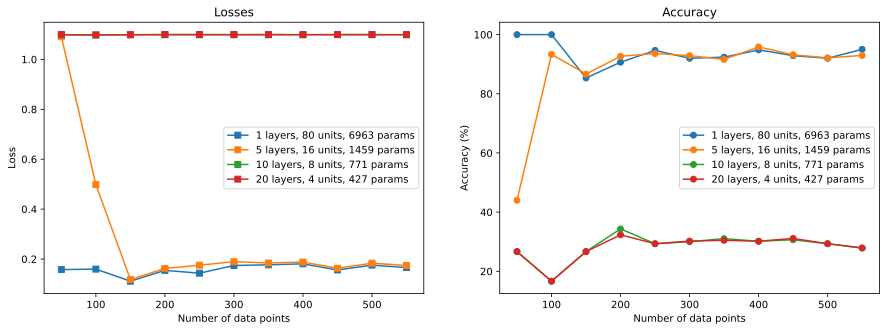

In [24]:
# Show the results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(n_data_points, results[:, :, 1], 's-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Number of data points')
ax[0].legend(legend)
ax[0].set_title('Losses')

ax[1].plot(n_data_points, results[:, :, 0], 'o-')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Number of data points')
ax[1].set_title('Accuracy')
ax[1].legend(legend)

plt.show()

In [ ]:
# Interpretation: 
#   Learning depends more on the architecture and the nature of the problem, than on the number of parameters.

# Additional explorations

In [ ]:
# 1) The model learns faster and better with the Adam optimizer. In fact, I intentionally used SGD here to make the
#    model worse for this demonstration! Change the optimizer to Adam. What do you think is a good learning rate?
#    More importantly: Do the conclusions of this experiment hold for the Adam optimizer?
# 
# 2) Add a timer to the experiment loop. Does the training duration relate to the number of layers or the number
#    of parameters?
# 
# 3) Do the two deepest models eventually learn if you increase the number of training epochs? (Note: because this 
#    question is only about the deepest models and because training time will increase, you need only test the two
#    models, not all four.)
# 